# Examine changes in viable habitat

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import os
import shutil
from itertools import product

import data_collections as dc
import funnel
import intake
import matplotlib.pyplot as plt
import metabolic as mi
import numpy as np
import operators as ops
import util
import xarray as xr
import yaml

/glade/work/mclong/miniconda3/envs/metabolic/lib/python3.7/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [6]:
curator = util.curator_local_assets()
cat = curator.open_catalog()
ds_ts = cat['trait-space'].to_dask().load()
trait_spc_wgt = ds_ts.trait_spc_active
trait_spc_wgt

<xarray.DataArray 'trait_spc_active' (Ac: 8, Eo: 7)>
array([[1.34680503e-03, 4.47545908e-03, 9.02342586e-03, 1.10384049e-02,
        8.19298555e-03, 3.68959807e-03, 1.00813091e-03],
       [1.06140909e-02, 3.52708287e-02, 7.11130864e-02, 8.69930173e-02,
        6.45684353e-02, 2.90775046e-02, 7.94502019e-03],
       [1.23591079e-02, 4.10695540e-02, 8.28044832e-02, 1.01295165e-01,
        7.51838542e-02, 3.38580121e-02, 9.25122680e-03],
       [7.08526930e-03, 2.35444865e-02, 4.74704214e-02, 5.80708193e-02,
        4.31016426e-02, 1.94102305e-02, 5.30357316e-03],
       [2.56701395e-03, 8.53023685e-03, 1.71986736e-02, 2.10392290e-02,
        1.56158521e-02, 7.03238370e-03, 1.92150019e-03],
       [6.36403263e-04, 2.11478032e-03, 4.26382256e-03, 5.21595685e-03,
        3.87141615e-03, 1.74343888e-03, 4.76370216e-04],
       [1.11418788e-04, 3.70246781e-04, 7.46491996e-04, 9.13187634e-04,
        6.77791144e-04, 3.05233896e-04, 8.34008799e-05],
       [1.39113912e-05, 4.62278214e-05, 9.32045879e-05, 1.14017669e-04,
        8.46268206e-05, 3.81105218e-05, 1.04131654e-05]])
Coordinates:
  * Ac       (Ac) float64 0.0258 0.0399 0.0619 0.0959 ... 0.2303 0.3568 0.5528
  * Eo       (Eo) float64 -0.2 -0.0 0.2 0.4 0.6 0.8 1.0
Attributes:
    N_traits:            56
    long_name:           Trait density (active)
    metabolic_baseline:  active
    units:               eV 1/kPa

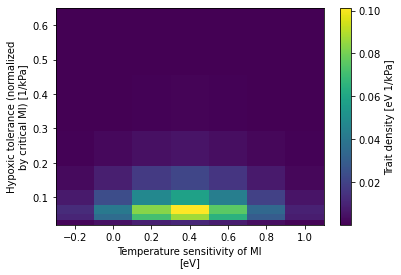

In [4]:
trait_spc_wgt.plot();

In [5]:
dEodT_bar = mi.dEodT_bar
dEodT_bar

0.022

In [6]:
catalog_json_file = funnel.to_intake_esm(agg_member_id=True)

sub_spec = dict(
    name='drift-corrected',
    experiment=['20C', 'RCP85'],
    member_id=dc.ocean_bgc_member_ids[:],
)

catalog = funnel.to_intake_esm(agg_member_id=True).search(**sub_spec)
catalog

,unique
experiment,2
component,1
stream,1
member_id,32
variable,8
name,1
path,413


In [7]:
catalog.search(experiment='20C', variable=['pO2', 'TEMP'], member_id=10).df

,experiment,component,stream,member_id,variable,name,path
0,20C,ocn,pop.h,10,TEMP,drift-corrected,/glade/scratch/mclong/ocean-metabolism/funnel-...
1,20C,ocn,pop.h,10,pO2,drift-corrected,/glade/scratch/mclong/ocean-metabolism/funnel-...


In [8]:
cache_dir = '/glade/scratch/mclong/ocean-metabolism/funnel-cache'


def _gen_cache_file_name(experiment, component, stream, member_id, variable):
    return f'{cache_dir}/glade-cesm1-le.{experiment}.{component}.{stream}.{int(member_id):03d}.{variable}.drift-corrected.zarr'


def _make_cache(experiment, component, stream, member_id, variable):
    """
    Manually generate funnel catalog entry

    I.e.:
    asset: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.101.TEMP.drift-corrected.zarr
    esm_collection: data/catalogs/glade-cesm1-le.json
    key: 20C.ocn.pop.h.101
    name: drift-corrected
    operator_kwargs:
    - {}
    - {}
    - {}
    operators:
    - compute_time
    - sel_time_slice
    - compute_drift_correction
    preprocess: _preprocess_pop_h_upper_1km
    variable: TEMP
    """

    cache_id_dict = dict(
        asset=_gen_cache_file_name(experiment, component, stream, member_id, variable),
        esm_collection='data/catalogs/glade-cesm1-le.json',
        key=f'{experiment}.{component}.{stream}.{member_id}',
        name='drift-corrected',
        operator_kwargs=[{}, {}, {}],
        operators=['compute_time', 'sel_time_slice', 'compute_drift_correction'],
        preprocess='_preprocess_pop_h_upper_1km',
        variable=variable,
    )
    cache_id_file = f'data/funnel-catalog/glade-cesm1-le.{experiment}.{component}.{stream}.{int(member_id):03d}.{variable}.drift-corrected.yml'
    with open(cache_id_file, 'w') as fid:
        yaml.dump(cache_id_dict, fid)

In [9]:
try:
    cluster
    client
except:
    cluster, client = util.get_ClusterClient(memory='64GB')
    cluster.scale(200)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/calcs/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/calcs/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.205.22:46710,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/calcs/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [10]:
# refresh catalog
catalog = funnel.to_intake_esm(agg_member_id=False).search(**sub_spec)
experiment_list = sorted(catalog.unique('experiment')['experiment']['values'])
member_id_list = sorted(catalog.unique('member_id')['member_id']['values'])

In [11]:
clobber = False

stream = 'pop.h'
component = 'ocn'

variable = 'depth_habitat_trait_wgt'

for experiment, member_id in product(experiment_list, member_id_list):

    # check for existing cache file
    asset = _gen_cache_file_name(experiment, component, stream, member_id, variable)

    if clobber and os.path.exists(asset):
        print(f'removing: {asset}')
        shutil.rmtree(asset)

    if os.path.exists(asset):
        print(f'exists: {asset}')
        continue

    with util.timer(f'{experiment}.{member_id}'):

        cat = catalog.search(
            experiment=experiment,
            member_id=member_id,
            stream=stream,
            component=component,
            variable=['TEMP', 'pO2'],
        )

        # ensure variables
        missing_vars = {'TEMP', 'pO2'} - set(cat.df.variable.to_list())
        if missing_vars:
            print(f'missing vars for {experiment}.{member_id:03d}: {missing_vars}')
            continue

        dset = cat.to_dataset_dict()
        assert len(dset.keys()) == 1
        _, ds = dset.popitem()

        # compute
        print(f'computing: {asset}')

        # compute trait-density weighted sum of viable habitat over depth
        var_out = xr.full_like(ds.TEMP[:, 0, :, :], fill_value=0.0)
        dso = ds[['TAREA', 'KMT', 'TLONG', 'TLAT', 'KMT', 'z_t', 'dz']]
        for Eo, Ac in product(trait_spc_wgt.Eo.values, trait_spc_wgt.Ac.values):
            # get the trait weighting for this trait
            trait_wgt_ij = trait_spc_wgt.sel(Eo=Eo, Ac=Ac).values

            # compute the metabolic index
            Phi = mi.Phi(ds.pO2, ds.TEMP, Ac, Eo, dEodT=dEodT_bar)

            # compute the vertical integral of habitat volume where Φ > 1
            # multiplied by trait space weighting
            viable_trait_mask = xr.where(Phi > 1, trait_wgt_ij, 0.0)

            # add this "viable depth" to total depth
            var_out += (ds.dz * viable_trait_mask).sum('z_t')

        print(f'writing: {asset}')
        var_out.name = variable
        var_out.attrs['long_name'] = 'Trait-space weighted vertical habitat'
        var_out.attrs['units'] = ' '.join([ds.z_t.attrs['units'], trait_spc_wgt.attrs['units']])
        dso[variable] = var_out
        dso.to_zarr(asset, mode='w', consolidated=True)
        _make_cache(experiment, component, stream, member_id, variable)

exists: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.002.depth_habitat_trait_wgt.drift-corrected.zarr
exists: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.009.depth_habitat_trait_wgt.drift-corrected.zarr
exists: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.010.depth_habitat_trait_wgt.drift-corrected.zarr
exists: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.011.depth_habitat_trait_wgt.drift-corrected.zarr
exists: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.012.depth_habitat_trait_wgt.drift-corrected.zarr
exists: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.013.depth_habitat_trait_wgt.drift-corrected.zarr
exists: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.014.depth_habitat_trait_wgt.drift-corrected.zarr
exists: /glade/scratch/mclong/ocea

In [12]:
del client
del cluster